In [ ]:
import pandas as pd
import numpy as np
# Load the raw data
fp = "/Users/gloriastucchi/Desktop/introtoml/project2/WineStudy/wine_data_fixed.csv"
df = pd.read_csv(fp)

# df standardise:
df = (df - df.mean()) / df.std()


y = df['Alcohol'].values
df = df.drop(columns=['Alcohol'])

#X = df.drop(columns=['Alcohol'])
X = df
X = X.values
print(X.shape)


print(y.shape)

# Headings
attributeNames = df.columns.tolist()

In [ ]:
y = y.reshape(-1,1)

print(y.shape)

In [ ]:
df.head()

In [ ]:
import importlib_resources
import numpy as np
import sklearn.linear_model as lm
from matplotlib.pyplot import clim, figure, plot, show, subplot, title, xlabel, ylabel
from scipy.io import loadmat
from sklearn import model_selection

from dtuimldmtools import bmplot, feature_selector_lr

#filename = importlib_resources.files("dtuimldmtools").joinpath("data/body.mat")
# Load data from matlab file
#mat_data = loadmat(filename)

#X = mat_data['X']
#y = mat_data['y'].squeeze()

print("X dataset", X.shape)
print("y dataset", y.shape)

#attributeNames = [name[0] for name in mat_data['attributeNames'][0]]
N, M = X.shape


## Crossvalidation
# Create crossvalidation partition for evaluation
K = 5
CV = model_selection.KFold(n_splits=K,shuffle=True)

# Initialize variables
Features = np.zeros((M,K))
Error_train = np.empty((K,1))
Error_test = np.empty((K,1))
Error_train_fs = np.empty((K,1))
Error_test_fs = np.empty((K,1))
Error_train_nofeatures = np.empty((K,1))
Error_test_nofeatures = np.empty((K,1))

k=0
for train_index, test_index in CV.split(X):
    
    # extract training and test set for current CV fold
    X_train = X[train_index,:]
    y_train = y[train_index]
    X_test = X[test_index,:]
    y_test = y[test_index]
    internal_cross_validation = 10
    
    # Compute squared error without using the input data at all
    Error_train_nofeatures[k] = np.square(y_train-y_train.mean()).sum()/y_train.shape[0]
    Error_test_nofeatures[k] = np.square(y_test-y_test.mean()).sum()/y_test.shape[0]

    # Compute squared error with all features selected (no feature selection)
    m = lm.LinearRegression(fit_intercept=True).fit(X_train, y_train)
    Error_train[k] = np.square(y_train-m.predict(X_train)).sum()/y_train.shape[0]
    Error_test[k] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]

    # Compute squared error with feature subset selection
    textout = ''
    selected_features, features_record, loss_record = feature_selector_lr(X_train, y_train, internal_cross_validation,display=textout)
    
    Features[selected_features,k] = 1
    # .. alternatively you could use module sklearn.feature_selection
    if len(selected_features) == 0:
        print('No features were selected, i.e. the data (X) in the fold cannot describe the outcomes (y).' )
    else:
        m = lm.LinearRegression(fit_intercept=True).fit(X_train[:,selected_features], y_train)
        Error_train_fs[k] = np.square(y_train-m.predict(X_train[:,selected_features])).sum()/y_train.shape[0]
        Error_test_fs[k] = np.square(y_test-m.predict(X_test[:,selected_features])).sum()/y_test.shape[0]
    
        figure(k)
        subplot(1,2,1)
        plot(range(1,len(loss_record)), loss_record[1:])
        xlabel('Iteration')
        ylabel('Squared error (crossvalidation)')    
        
        subplot(1,3,3)
        bmplot(attributeNames, range(1,features_record.shape[1]), -features_record[:,1:])
        clim(-1.5,0)
        xlabel('Iteration')

    print('Cross validation fold {0}/{1}'.format(k+1,K))
    print('Train indices: {0}'.format(train_index))
    print('Test indices: {0}'.format(test_index))
    print('Features no: {0}\n'.format(selected_features.size))

    k+=1


# Display results
print('\n')
print('Linear regression without feature selection:\n')
print('- Training error: {0}'.format(Error_train.mean()))
print('- Test error:     {0}'.format(Error_test.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}'.format((Error_test_nofeatures.sum()-Error_test.sum())/Error_test_nofeatures.sum()))
print('Linear regression with feature selection:\n')
print('- Training error: {0}'.format(Error_train_fs.mean()))
print('- Test error:     {0}'.format(Error_test_fs.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train_fs.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}'.format((Error_test_nofeatures.sum()-Error_test_fs.sum())/Error_test_nofeatures.sum()))

figure(k)
subplot(1,3,2)
bmplot(attributeNames, range(1,Features.shape[1]+1), -Features)
clim(-1.5,0)
xlabel('Crossvalidation fold')
ylabel('Attribute')


# Inspect selected feature coefficients effect on the entire dataset and
# plot the fitted model residual error as function of each attribute to
# inspect for systematic structure in the residual

f=2 # cross-validation fold to inspect
ff=Features[:,f-1].nonzero()[0]
if len(ff) == 0:
    print('\nNo features were selected, i.e. the data (X) in the fold cannot describe the outcomes (y).' )
else:
    m = lm.LinearRegression(fit_intercept=True).fit(X[:,ff], y)
    
    y_est= m.predict(X[:,ff])
    residual=y-y_est
    
    figure(k+1, figsize=(12,6))
    title('Residual error vs. Attributes for features selected in cross-validation fold {0}'.format(f))
    for i in range(0,len(ff)):
       subplot(2, int( np.ceil(len(ff)/2)), i+1)
       plot(X[:,ff[i]],residual,'.')
       xlabel(attributeNames[ff[i]])
       ylabel('residual error')
    
    
show()

print('Ran Exercise 6.2.1')

In [ ]:
def PlotGenErr(testErr, k, lambdas):
    genErr = testErr * 1/k
    figure(k, figsize=(12,8))
    plot(genErr, lambdas)
    show()

In [ ]:
# exercise 8.1.1

import importlib_resources
import numpy as np
import sklearn.linear_model as lm
from matplotlib.pylab import (
    figure,
    grid,
    legend,
    loglog,
    semilogx,
    show,
    subplot,
    title,
    xlabel,
    ylabel,
)
from scipy.io import loadmat
from sklearn import model_selection

from dtuimldmtools import rlr_validate

#filename = importlib_resources.files("dtuimldmtools").joinpath("data/body.mat")


#mat_data = loadmat(filename)
#X = mat_data["X"]
#y = mat_data["y"].squeeze()
#attributeNames = [name[0] for name in mat_data["attributeNames"][0]]
N, M = X.shape

# Add offset attribute
X = np.concatenate((np.ones((X.shape[0], 1)), X), 1)
attributeNames = ["Offset"] + attributeNames
M = M + 1

## Crossvalidation
# Create crossvalidation partition for evaluation
K = 5
CV = model_selection.KFold(K, shuffle=True)
# CV = model_selection.KFold(K, shuffle=False)

# Values of lambda
lambdas = np.power(10.0, range(-5, 9))

# Initialize variables
# T = len(lambdas)
Error_train = np.empty((K, 1))
Error_test = np.empty((K, 1))
Error_train_rlr = np.empty((K, 1))
Error_test_rlr = np.empty((K, 1))
Error_train_nofeatures = np.empty((K, 1))
Error_test_nofeatures = np.empty((K, 1))
w_rlr = np.empty((M, K))
mu = np.empty((K, M - 1))
sigma = np.empty((K, M - 1))
w_noreg = np.empty((M, K))

k = 0
for train_index, test_index in CV.split(X, y):
    # extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    internal_cross_validation = 10

    (
        opt_val_err,
        opt_lambda,
        mean_w_vs_lambda,
        train_err_vs_lambda,
        test_err_vs_lambda,
    ) = rlr_validate(X_train, y_train, lambdas, internal_cross_validation)

    # Standardize outer fold based on training set, and save the mean and standard
    # deviations since they're part of the model (they would be needed for
    # making new predictions) - for brevity we won't always store these in the scripts
    mu[k, :] = np.mean(X_train[:, 1:], 0)
    sigma[k, :] = np.std(X_train[:, 1:], 0)

    X_train[:, 1:] = (X_train[:, 1:] - mu[k, :]) / sigma[k, :]
    X_test[:, 1:] = (X_test[:, 1:] - mu[k, :]) / sigma[k, :]

    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train

    # Compute mean squared error without using the input data at all
    Error_train_nofeatures[k] = (
        np.square(y_train - y_train.mean()).sum(axis=0) / y_train.shape[0]
    )
    Error_test_nofeatures[k] = (
        np.square(y_test - y_test.mean()).sum(axis=0) / y_test.shape[0]
    )

    # Estimate weights for the optimal value of lambda, on entire training set
    lambdaI = opt_lambda * np.eye(M)
    lambdaI[0, 0] = 0  # Do no regularize the bias term
    w_rlr[:, k] = np.linalg.solve(XtX + lambdaI, Xty).squeeze()

    # Compute mean squared error with regularization with optimal lambda
    Error_train_rlr[k] = (
        np.square(y_train - X_train @ w_rlr[:, k]).sum(axis=0) / y_train.shape[0]
    )
    Error_test_rlr[k] = (
        np.square(y_test - X_test @ w_rlr[:, k]).sum(axis=0) / y_test.shape[0]
    )

    # Estimate weights for unregularized linear regression, on entire training set
    w_noreg[:, k] = np.linalg.solve(XtX, Xty).squeeze()
    # Compute mean squared error without regularization
    Error_train[k] = (
        np.square(y_train - X_train @ w_noreg[:, k]).sum(axis=0) / y_train.shape[0]
    )
    Error_test[k] = (
        np.square(y_test - X_test @ w_noreg[:, k]).sum(axis=0) / y_test.shape[0]
    )
    # OR ALTERNATIVELY: you can use sklearn.linear_model module for linear regression:
    # m = lm.LinearRegression().fit(X_train, y_train)
    # Error_train[k] = np.square(y_train-m.predict(X_train)).sum()/y_train.shape[0]
    # Error_test[k] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]

    # Display the results for the last cross-validation fold
    if k == K - 1:
        figure(k, figsize=(12, 8))
        subplot(1, 2, 1)
        semilogx(lambdas, mean_w_vs_lambda.T[:, 1:], ".-")  # Don't plot the bias term
        xlabel("Regularization factor")
        ylabel("Mean Coefficient Values")
        grid()
        # You can choose to display the legend, but it's omitted for a cleaner
        # plot, since there are many attributes
        # legend(attributeNames[1:], loc='best')

        subplot(1, 2, 2)
        title("Optimal lambda: 1e{0}".format(np.log10(opt_lambda)))
        loglog(
            lambdas, train_err_vs_lambda.T, "b.-", lambdas, test_err_vs_lambda.T, "r.-"
        )
        xlabel("Regularization factor")
        ylabel("Squared error (crossvalidation)")
        legend(["Train error", "Validation error"])
        grid()

        #PlotGenErr(test_err_vs_lambda, k, lambdas)


    # To inspect the used indices, use these print statements
    # print('Cross validation fold {0}/{1}:'.format(k+1,K))
    # print('Train indices: {0}'.format(train_index))
    # print('Test indices: {0}\n'.format(test_index))

    k += 1

show()




# Display results
print("Linear regression without feature selection:")
print("- Training error: {0}".format(Error_train.mean()))
print("- Test error:     {0}".format(Error_test.mean()))
print(
    "- R^2 train:     {0}".format(
        (Error_train_nofeatures.sum() - Error_train.sum())
        / Error_train_nofeatures.sum()
    )
)
print(
    "- R^2 test:     {0}\n".format(
        (Error_test_nofeatures.sum() - Error_test.sum()) / Error_test_nofeatures.sum()
    )
)
print("Regularized linear regression:")
print("- Training error: {0}".format(Error_train_rlr.mean()))
print("- Test error:     {0}".format(Error_test_rlr.mean()))
print(
    "- R^2 train:     {0}".format(
        (Error_train_nofeatures.sum() - Error_train_rlr.sum())
        / Error_train_nofeatures.sum()
    )
)
print(
    "- R^2 test:     {0}\n".format(
        (Error_test_nofeatures.sum() - Error_test_rlr.sum())
        / Error_test_nofeatures.sum()
    )
)

print("Weights in last fold:")
for m in range(M):
    print("{:>15} {:>15}".format(attributeNames[m], np.round(w_rlr[m, -1], 2)))

print("Ran Exercise 8.1.1")



# ANN Stuff

In [ ]:
# Retain the splits so that we can re-run the models on the same data
K = 5  
CV = model_selection.KFold(K, shuffle=True, random_state=123)
splits = list(CV.split(X, y)) #list because the generator can be exhausted.



In [ ]:
# exercise 8.2.6
import importlib_resources
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy import stats
from scipy.io import loadmat
from sklearn import model_selection

from dtuimldmtools import draw_neural_net, train_neural_net

N, M = X.shape
C = 2

# Normalize data
X = stats.zscore(X)

## Normalize and compute PCA (change to True to experiment with PCA preprocessing)
do_pca_preprocessing = False
if do_pca_preprocessing:
    Y = stats.zscore(X, 0)
    U, S, V = np.linalg.svd(Y, full_matrices=False)
    V = V.T
    # Components to be included as features
    k_pca = 3
    X = X @ V[:, :k_pca]
    N, M = X.shape


# Parameters for neural network classifier
n_hidden_units = 20  # number of hidden units
n_replicates = 1  # number of networks trained in each k-fold
max_iter = 10000

# K-fold crossvalidation
#K = 5  # only three folds to speed up this example
#CV = model_selection.KFold(K, shuffle=True, random_state=123)

# Setup figure for display of learning curves and error rates in fold
summaries, summaries_axes = plt.subplots(1, 2, figsize=(10, 5))
# Make a list for storing assigned color of learning curve for up to K=10
color_list = [
    "tab:orange",
    "tab:green",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:gray",
    "tab:olive",
    "tab:cyan",
    "tab:red",
    "tab:blue",
]
# Define the model
model = lambda: torch.nn.Sequential(
    torch.nn.Linear(M, n_hidden_units),  # M features to n_hidden_units
    torch.nn.Tanh(),  # 1st transfer function,
    torch.nn.Linear(n_hidden_units, 1),  # n_hidden_units to 1 output neuron
    # no final tranfer function, i.e. "linear output"
)
loss_fn = torch.nn.MSELoss()  # notice how this is now a mean-squared-error loss

print("Training model of type:\n\n{}\n".format(str(model())))
errors = []  # make a list for storing generalizaition error in each loop
for k, (train_index, test_index) in enumerate(splits):
    print("\nCrossvalidation fold: {0}/{1}".format(k + 1, K))

    # Extract training and test set for current CV fold, convert to tensors
    X_train = torch.Tensor(X[train_index, :])
    y_train = torch.Tensor(y[train_index])
    X_test = torch.Tensor(X[test_index, :])
    y_test = torch.Tensor(y[test_index])

    # Train the net on training data
    net, final_loss, learning_curve = train_neural_net(
        model,
        loss_fn,
        X=X_train,
        y=y_train,
        n_replicates=n_replicates,
        max_iter=max_iter,
    )

    print("\n\tBest loss: {}\n".format(final_loss))

    # Determine estimated class labels for test set
    y_test_est = net(X_test)

    # Determine errors and errors
    se = (y_test_est.float() - y_test.float()) ** 2  # squared error
    mse = (sum(se).type(torch.float) / len(y_test)).data.numpy()  # mean
    errors.append(mse)  # store error rate for current CV fold

    # Display the learning curve for the best net in the current fold
    (h,) = summaries_axes[0].plot(learning_curve, color=color_list[k])
    h.set_label("CV fold {0}".format(k + 1))
    summaries_axes[0].set_xlabel("Iterations")
    summaries_axes[0].set_xlim((0, max_iter))
    summaries_axes[0].set_ylabel("Loss")
    summaries_axes[0].set_title("Learning curves")

# Display the MSE across folds
summaries_axes[1].bar(
    np.arange(1, K + 1), np.squeeze(np.asarray(errors)), color=color_list
)
summaries_axes[1].set_xlabel("Fold")
summaries_axes[1].set_xticks(np.arange(1, K + 1))
summaries_axes[1].set_ylabel("MSE")
summaries_axes[1].set_title("Test mean-squared-error")

print("Diagram of best neural net in last fold:")
weights = [net[i].weight.data.numpy().T for i in [0, 2]]
biases = [net[i].bias.data.numpy() for i in [0, 2]]
tf = [str(net[i]) for i in [1, 2]]
draw_neural_net(weights, biases, tf, attribute_names=attributeNames)

# Print the average classification error rate
print(
    "\nEstimated generalization error, RMSE: {0}".format(
        round(np.sqrt(np.mean(errors)), 4)
    )
)

# When dealing with regression outputs, a simple way of looking at the quality
# of predictions visually is by plotting the estimated value as a function of
# the true/known value - these values should all be along a straight line "y=x",
# and if the points are above the line, the model overestimates, whereas if the
# points are below the y=x line, then the model underestimates the value
plt.figure(figsize=(10, 10))
y_est = y_test_est.data.numpy()
y_true = y_test.data.numpy()
axis_range = [np.min([y_est, y_true]) - 1, np.max([y_est, y_true]) + 1]
plt.plot(axis_range, axis_range, "k--")
plt.plot(y_true, y_est, "ob", alpha=0.25)
plt.legend(["Perfect estimation", "Model estimations"])
plt.title("Alcohol content: estimated versus true value (for last CV-fold)")
plt.ylim(axis_range)
plt.xlim(axis_range)
plt.xlabel("True value")
plt.ylabel("Estimated value")
plt.grid()

plt.show()

print("Ran Exercise 8.2.5")


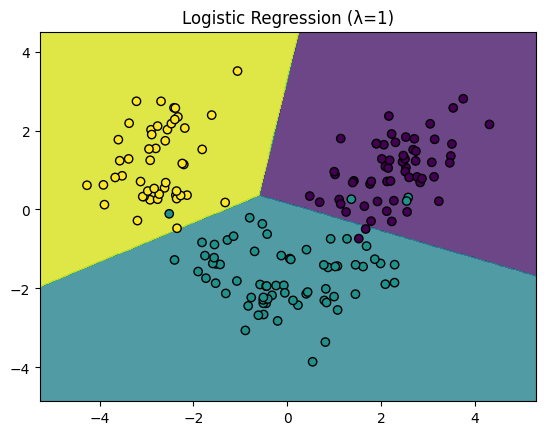

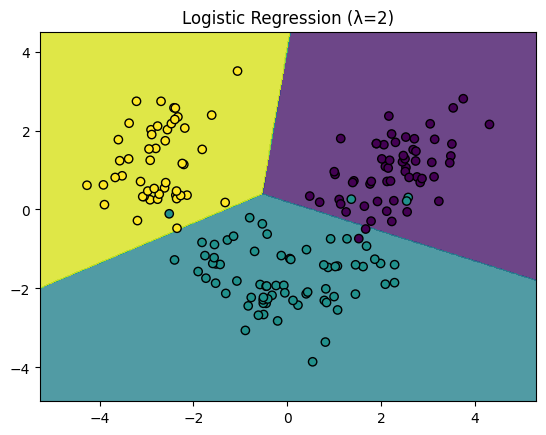

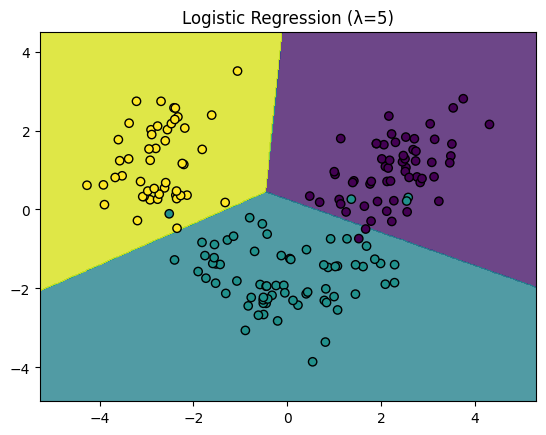

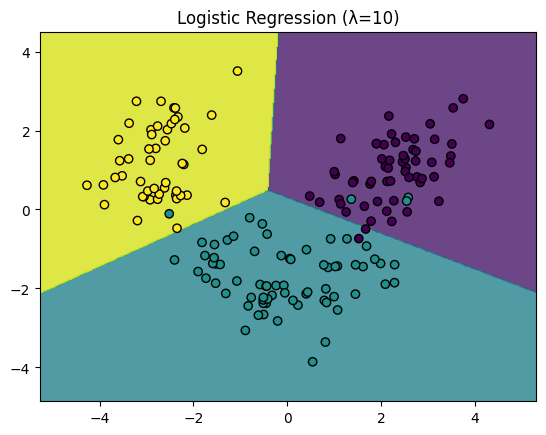

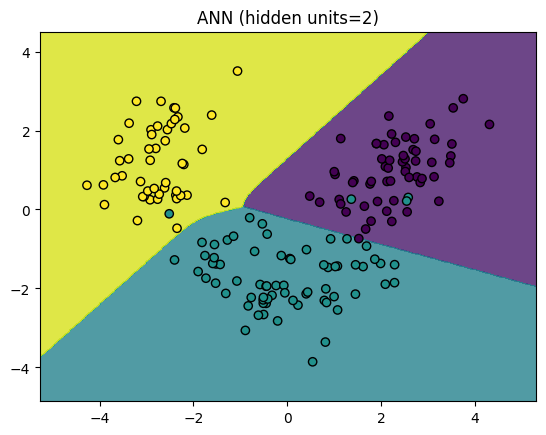

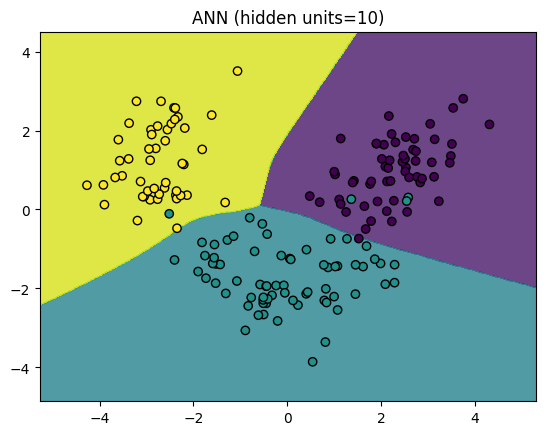

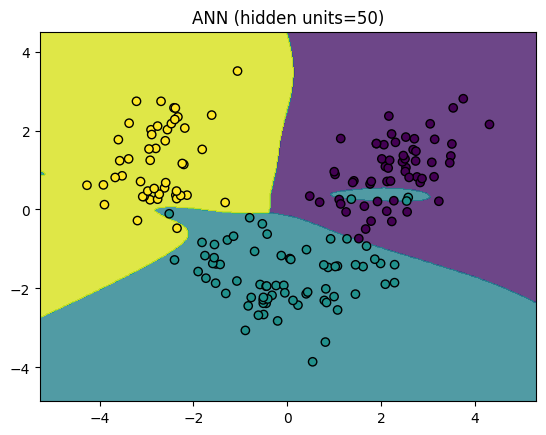

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn

# ANN Classifier (already defined in your code)
class ANNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_units, num_classes):
        super(ANNClassifier, self).__init__()
        self.hidden = nn.Linear(input_dim, hidden_units)
        self.output = nn.Linear(hidden_units, num_classes)
        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.activation(self.hidden(x))
        x = self.output(x)
        return x

def plot_decision_boundary(model, X, y, title):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    if isinstance(model, nn.Module):
        # For ANN model
        model.eval()
        with torch.no_grad():
            inputs = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
            outputs = model(inputs)
            _, Z = torch.max(outputs, 1)
            Z = Z.numpy()
    else:
        # For Logistic Regression
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
    plt.title(title)
    plt.show()

# Step 1: Load data and reduce dimensions using PCA for visualization
def reduce_dimensionality(X):
    pca = PCA(n_components=2)
    return pca.fit_transform(X)

# Reduce data to 2D for visualization
X_2d = reduce_dimensionality(X)
y = y.astype(int)

# Step 2: Visualize Logistic Regression boundaries with different λ values
lambdas = [1, 2, 5, 10]
for lambd in lambdas:
    model = LogisticRegression(C=1/lambd, max_iter=1000, multi_class='multinomial')
    model.fit(X_2d, y)
    plot_decision_boundary(model, X_2d, y, f"Logistic Regression (λ={lambd})")

# Step 3: Visualize ANN boundaries with different hidden units
hidden_units_list = [2, 10, 50]
for hidden_units in hidden_units_list:
    input_dim = X_2d.shape[1]
    num_classes = len(np.unique(y))
    ann_model = ANNClassifier(input_dim, hidden_units, num_classes)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(ann_model.parameters(), lr=0.01)
    
    # Convert data to tensors
    X_tensor = torch.FloatTensor(X_2d)
    y_tensor = torch.LongTensor(y)
    
    # Train the ANN
    for epoch in range(1000):
        ann_model.train()
        optimizer.zero_grad()
        outputs = ann_model(X_tensor)
        loss = criterion(outputs, y_tensor)
        loss.backward()
        optimizer.step()

    plot_decision_boundary(ann_model, X_2d, y, f"ANN (hidden units={hidden_units})")


In [32]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from matplotlib.colors import ListedColormap

def plot_decision_boundary(X, y, model):
    # Create a mesh grid
    x_min, x_max = X[1:, 0].min() - 0.1, X[1:, 0].max() + 0.1
    y_min, y_max = X[1:, 1].min() - 0.1, X[1:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    # Predict on the mesh grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary
    plt.contourf(xx, yy, Z, alpha=0.5, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']))
    
    # Scatter plot of actual data
    scatter = plt.scatter(X[1:, 0], X[1:, 1], c=y, edgecolor='k', cmap=ListedColormap(['#FF0000', '#0000FF']))
    plt.legend(handles=scatter.legend_elements()[0], labels=['Negative Class', 'Positive Class'])
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary with Actual Data')
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
    
    # Display confusion matrix
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

# Generate synthetic data
X, y = make_classification(n_samples=100, n_features=13, n_classes=3, n_clusters_per_class=1, random_state=42)

# Train a classifier
model = LogisticRegression()
model.fit(X, y)

# Predictions
y_pred = model.predict(X)

# Plot decision boundary with initial data
plot_decision_boundary(X, y, model)

# Plot confusion matrix for initial predictions
plot_confusion_matrix(y, y_pred)


ValueError: X has 2 features, but LogisticRegression is expecting 13 features as input.

In [38]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from collections import Counter
from sklearn.preprocessing import StandardScaler
from dtuimldmtools import rlr_validate  # Assuming this is the correct import

# Load dataset function
def load_data(filepath):
    data = pd.read_csv(filepath)
    y = data.iloc[1:, 0] - 1  # Adjust labels to be zero-indexed for PyTorch
    X = data.iloc[1:, 1:]
    return X.values, y.values

# Function for ANN classifier
class ANNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_units, num_classes):
        super(ANNClassifier, self).__init__()
        self.hidden = nn.Linear(input_dim, hidden_units)
        self.output = nn.Linear(hidden_units, num_classes)
        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.activation(self.hidden(x))
        x = self.output(x)
        return x

# Function to train ANN
def train_ann(X_train, y_train, X_val, hidden_units, max_iter=100):
    input_dim = X_train.shape[1]
    num_classes = len(np.unique(y_train))
    model = ANNClassifier(input_dim, hidden_units, num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.LongTensor(y_train)
    X_val_tensor = torch.FloatTensor(X_val)

    for epoch in range(max_iter):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        outputs_val = model(X_val_tensor)
        _, predictions = torch.max(outputs_val, 1)
    return predictions.numpy()

# Baseline method
def baseline_method(y_train, y_test):
    most_common_class = Counter(y_train).most_common(1)[0][0]
    predictions = np.full_like(y_test, most_common_class)
    return predictions

# Load the data
filepath = "/Users/gloriastucchi/Desktop/introtoml/project2/WineStudy/raw_data/wine.csv"
X, y = load_data(filepath)

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Define cross-validation parameters
K1 = 5  # Outer folds
K2 = 5  # Inner folds
kf_outer = KFold(n_splits=K1, shuffle=True, random_state=42)

# Define the set of discrete lambda values
#lambdas = np.array([0.1, 1, 2])
lambdas = np.power(10.0, range(-5, 9))

results_summary = []

# Outer cross-validation loop
for outer_fold, (train_index, test_index) in enumerate(kf_outer.split(X), start=1):
    X_outer_train, X_outer_test = X[train_index], X[test_index]
    y_outer_train, y_outer_test = y[train_index], y[test_index]
    print(f"Class distribution in training set for fold {outer_fold}: {np.bincount(y_outer_train)}")
    print(f"Class distribution in test set for fold {outer_fold}: {np.bincount(y_outer_test)}")
    # Check class distribution of predictions
    #print(f"Class distribution in ANN predictions for fold {outer_fold}: {np.bincount(ann_pred)}")
    #print(f"Class distribution in Logistic Regression predictions for fold {outer_fold}: {np.bincount(logreg_pred)}")



    # Inner cross-validation for Logistic Regression using rlr_validate
    internal_cv = K2
    opt_val_err, best_lambda, _, _, _ = rlr_validate(X_outer_train, y_outer_train, lambdas, internal_cv)

    # Train Logistic Regression on outer fold with best lambda
    logreg_model = LogisticRegression(C=1/best_lambda, max_iter=1000, multi_class='multinomial')
    logreg_model.fit(X_outer_train, y_outer_train)
    logreg_pred = logreg_model.predict(X_outer_test)
    logreg_error_rate = np.mean(logreg_pred != y_outer_test)

    # Inner cross-validation for ANN
    hidden_units_values = [1, 2, 5, 10]
    best_ann_error_rate = float('inf')
    best_hidden_units = None

    for hidden_units in hidden_units_values:
        inner_error_rates = []
        for train_idx, val_idx in KFold(n_splits=K2, shuffle=True, random_state=42).split(X_outer_train):
            X_train, X_val = X_outer_train[train_idx], X_outer_train[val_idx]
            y_train, y_val = y_outer_train[train_idx], y_outer_train[val_idx]

            ann_pred = train_ann(X_train, y_train, X_val, hidden_units=hidden_units)
            val_error_rate = np.mean(ann_pred != y_val)
            inner_error_rates.append(val_error_rate)

        mean_error_rate = np.mean(inner_error_rates)
        if mean_error_rate < best_ann_error_rate:
            best_ann_error_rate = mean_error_rate
            best_hidden_units = hidden_units

    print(f"Selected hidden units for outer fold {outer_fold}: {best_hidden_units}")

    # Train final ANN with the best hyperparameters
    ann_pred = train_ann(X_outer_train, y_outer_train, X_outer_test, hidden_units=best_hidden_units)
    ann_error_rate = np.mean(ann_pred != y_outer_test)

    # Baseline model
    baseline_pred = baseline_method(y_outer_train, y_outer_test)
    baseline_error_rate = np.mean(baseline_pred != y_outer_test)

    # Store results
    results_summary.append({
        'Outer fold': outer_fold,
        'ANN Hidden Units': best_hidden_units,
        'ANN Error Rate': round(ann_error_rate, 4),
        'Logistic Regression (λ*)': best_lambda,
        'Logistic Error Rate': round(logreg_error_rate, 4),
        'Baseline Error Rate': round(baseline_error_rate, 4)
    })

# Convert results to DataFrame and print
results_df = pd.DataFrame(results_summary)
print("\nTwo-level cross-validation table:")
print(results_df.to_string(index=False))


Class distribution in training set for fold 1: [44 57 40]
Class distribution in test set for fold 1: [14 14  8]
Selected hidden units for outer fold 1: 2
Class distribution in training set for fold 2: [46 57 38]
Class distribution in test set for fold 2: [12 14 10]
Selected hidden units for outer fold 2: 2
Class distribution in training set for fold 3: [48 55 39]
Class distribution in test set for fold 3: [10 16  9]
Selected hidden units for outer fold 3: 2
Class distribution in training set for fold 4: [46 58 38]
Class distribution in test set for fold 4: [12 13 10]
Selected hidden units for outer fold 4: 10
Class distribution in training set for fold 5: [48 57 37]
Class distribution in test set for fold 5: [10 14 11]
Selected hidden units for outer fold 5: 2

Two-level cross-validation table:
 Outer fold  ANN Hidden Units  ANN Error Rate  Logistic Regression (λ*)  Logistic Error Rate  Baseline Error Rate
          1                 2          0.0833                  10.00000         

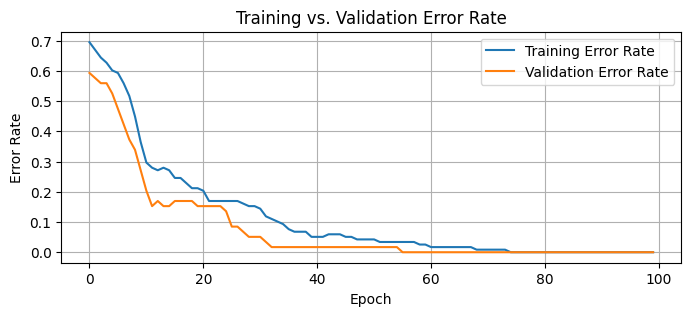

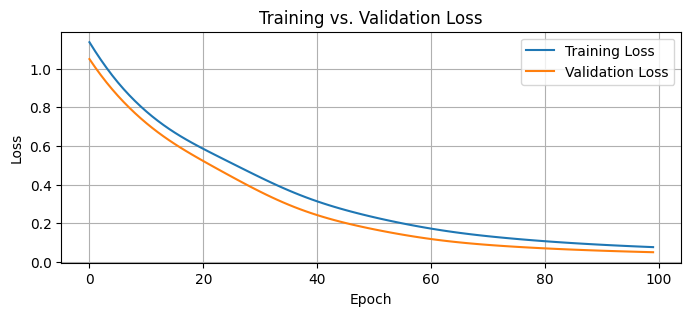

In [ ]:
import matplotlib.pyplot as plt

def train_ann_with_accuracy(X_train, y_train, X_val=None, y_val=None, hidden_units=20, max_iter=100):
    input_dim = X_train.shape[1]
    num_classes = len(np.unique(y_train))
    
    model = ANNClassifier(input_dim, hidden_units, num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Convert to tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.LongTensor(y_train)
    
    if X_val is not None and y_val is not None:
        X_val_tensor = torch.FloatTensor(X_val)
        y_val_tensor = torch.LongTensor(y_val)

    # Lists to store losses and accuracies
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(max_iter):
        # Training phase
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        train_pred = outputs.argmax(dim=1).numpy()
        train_acc = accuracy_score(y_train, train_pred)
        train_accuracies.append(train_acc)
        train_losses.append(loss.item())

        # Validation phase
        if X_val is not None and y_val is not None:
            model.eval()
            with torch.no_grad():
                outputs_val = model(X_val_tensor)
                val_loss = criterion(outputs_val, y_val_tensor)
                val_pred = outputs_val.argmax(dim=1).numpy()
                val_acc = accuracy_score(y_val, val_pred)
                
                val_accuracies.append(val_acc)
                val_losses.append(val_loss.item())

    return model, train_losses, val_losses, train_accuracies, val_accuracies


# Example usage on one fold
model, train_losses, val_losses, train_accuracies, val_accuracies = train_ann_with_accuracy(
    X_outer_train, y_outer_train, X_outer_test, y_outer_test, hidden_units=
)

# Plotting Training vs Validation Accuracy
plt.figure(figsize=(8, 3))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Training vs Validation Loss
plt.figure(figsize=(8, 3))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [30]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    train_sizes = np.linspace(0.1, 1.0, 10)  # 10 points from 10% to 100% of the data
    train_errors = []
    val_errors = []
    
    for train_size in train_sizes:
        # Split data into training and validation sets
        X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=train_size, random_state=42)

        # Train the model on the current subset of the training set
        model.fit(X_train, y_train)
        
        # Compute training error
        train_pred = model.predict(X_train)
        train_error = np.mean(train_pred != y_train)
        train_errors.append(train_error)
        
        # Compute validation error
        val_pred = model.predict(X_val)
        val_error = np.mean(val_pred != y_val)
        val_errors.append(val_error)
    
    # Plotting the learning curves
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_errors, label='Training Error', marker='o')
    plt.plot(train_sizes, val_errors, label='Validation Error', marker='o')
    plt.xlabel('Training Set Size')
    plt.ylabel('Error Rate')
    plt.title('Learning Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage with your Logistic Regression model
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(C=1.0, max_iter=1000)
plot_learning_curves(model, X, y)


InvalidParameterError: The 'train_size' parameter of train_test_split must be a float in the range (0.0, 1.0), an int in the range [1, inf) or None. Got np.float64(1.0) instead.